# Etterbehandling av "labelled sections" fra FEM-Design
Dette dokumentet beregner resultanter og plotter krefter i snitt eksportert fra FEM-Design.

## Eksempel-modell:
Figuren under viser en dekkeskive på 22x8m som spenner mellom to vegger. med tre labelled sections i hver retning. Snittene er tatt 0,5 m fra opplegg og midt i felt. Fargene indikerer skallkrefter Nx'. Lasten er en enhetslast påført i positiv y-retning. Resultatene er så eksportert til en teksfil som leses her.
![figur](figur1.png "FEM-Modell")
I FEM-Design under Analysis > Auxiliary Result Objects finner man "labelled sections". Disse snittene kan man så sette ut på et skall, se figur.
![labelled](labelled.png "Labelled Sections")
Resultatene kan så eksporteres til tekstfil via Tools > List...
![list_tables](list_tables.png "List Tables")


## Lesing av tekstfil:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("labeledSection.txt", sep='\t', header=None)
df.columns = ["ID", "x/Type", "Mx'", "My'", "Mx'y'", "Nx'", "Ny'", "Nx'y'", "Tx'z'", "Ty'z'", "Case"]
df.head()

,ID,x/Type,Mx',My',Mx'y',Nx',Ny',Nx'y',Tx'z',Ty'z',Case
0,P.1.1,0.0,0.022,0.011,0.013,0.034,-0.593,0.731,-0.006,-0.069,enhetslast
1,P.1.1,0.1,0.021,0.010,0.012,-0.073,-0.636,0.701,-0.004,-0.059,enhetslast
2,P.1.1,0.2,0.020,0.009,0.012,-0.180,-0.678,0.672,-0.003,-0.049,enhetslast
3,P.1.1,0.3,0.020,0.009,0.011,-0.287,-0.721,0.642,-0.001,-0.039,enhetslast
4,P.1.1,0.4,0.019,0.008,0.011,-0.394,-0.764,0.613,0.001,-0.029,enhetslast


Ordner felter med "NaN" og reduserer listen til bare skivekrefter:

In [3]:
df = df.fillna(method='ffill')
df = df.drop(df.columns[[2,3,4,8,9]], axis=1)
df.head()

,ID,x/Type,Nx',Ny',Nx'y',Case
0,P.1.1,0.0,0.034,-0.593,0.731,enhetslast
1,P.1.1,0.1,-0.073,-0.636,0.701,enhetslast
2,P.1.1,0.2,-0.180,-0.678,0.672,enhetslast
3,P.1.1,0.3,-0.287,-0.721,0.642,enhetslast
4,P.1.1,0.4,-0.394,-0.764,0.613,enhetslast


## Formler for beregning av resultanter:
* $ N_{Nx'}=\int_{0}^{L} N_{x'} \,dx \cdot w $
* $ M_{Nx'}=\int_{0}^{L} N_{x'} \cdot (x-\frac{L}{2})  \,dx \cdot w $
* $ N_{Ny'}=\int_{0}^{L} N_{y'} dx \cdot w $
* $ M_{Ny'}=\int_{0}^{L} N_{y'} \cdot (x-\frac{L}{2})  \,dx \cdot w $
* $ V=\int_{0}^{L} N_{x'y'} \,dx \cdot w $

Hvor: $w = x_{n+1}-x_{n}$ (bredde på kraftresultant i gitt koordinat langs x)

I kodeform blir dette:

In [4]:
def moment_integral(df, column_name):
    max_x = df["x/Type"].iloc[-1]
    force = df[column_name].rolling(window=2).mean()
    arm = df["x/Type"].rolling(window=2).mean()-max_x/2
    width = df["x/Type"].diff()
    moment = (force*arm*width).sum()
    return round(moment, 2)

def force_integral(df, column_name):
    force = df[column_name].rolling(window=2).mean()
    width = df["x/Type"].diff()
    res_force = (force * width).sum()
    return round(res_force, 2)

## Beregning av resultanter

In [5]:
header_names = ['ID', 'Nnx', 'Mnx', 'Nny', 'Mny','V','Case']
ids = df['ID'].unique()
cases = df['Case'].unique()
datalist = []
for id1 in ids:
    for case in cases:
        filter1 = (df['ID'] == id1) & (df['Case'] == case)
        df_temp = df.loc[filter1]
        Nnx = force_integral(df_temp,"Nx'")
        Mnx = moment_integral(df_temp,"Nx'")
        Nny = force_integral(df_temp,"Ny'")
        Mny = moment_integral(df_temp,"Ny'")
        V = force_integral(df_temp,"Nx'y'")
        datalist.append(dict(zip(header_names, [id1, Nnx, Mnx, Nny, Mny, V, case])))        

df_resultant = pd.DataFrame(datalist)

In [6]:
df_resultant

,Case,ID,Mnx,Mny,Nnx,Nny,V
0,enhetslast,P.1.1,0.00,0.00,-74.23,-21.33,0.0
1,enhetslast,P.1.2,-0.00,0.00,72.89,-0.34,-0.0
2,enhetslast,P.1.3,-0.00,0.00,0.40,-10.40,-0.0
3,enhetslast,RS1.1,4.85,4.59,-0.00,-2.72,10.5
4,enhetslast,RS2.1,59.96,6.40,-0.00,-4.01,0.0
5,enhetslast,RS3.1,4.85,4.59,-0.00,-2.72,-10.5


Kontroll av resultater vha. bjelketeori:
* Maks moment:  $M = \frac{ql^2}{8}=\frac{1\cdot22^2}{8}=60.5 kNm$
* Maks skjær: $V=ql/2=1 \cdot 22/2 = 11 kN$

## Plot av diagram

In [7]:
def plotDiagrams(df):
    x= df['x/Type']
    y1=df["Nx'"]
    y2=df["Ny'"]
    y3=df["Nx'y'"]
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True)
    ax1.set_title(df['ID'].iloc[0])
    ax1.fill_between(x, 0, y1)
    ax1.set_ylabel('Nx')
    
    ax2.fill_between(x, 0, y2)
    ax2.set_ylabel('Ny')
    
    ax3.fill_between(x, 0, y3)
    ax3.set_ylabel('Nxy')
    ax3.set_xlabel('x')

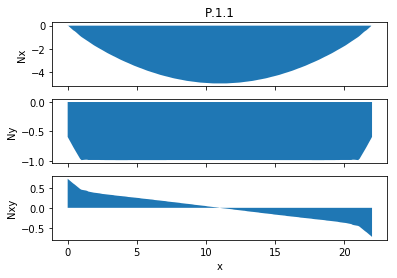

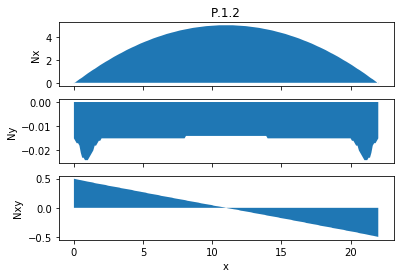

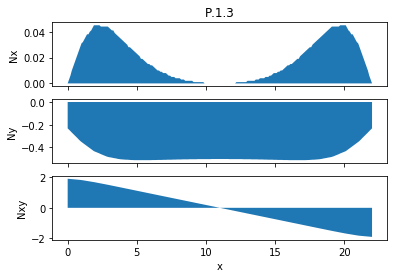

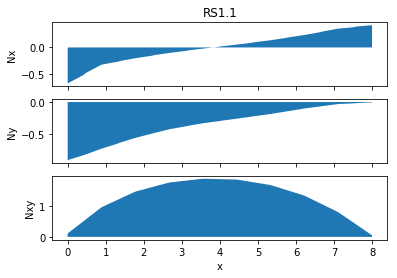

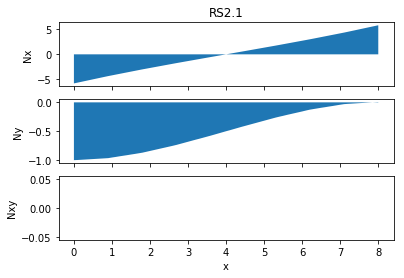

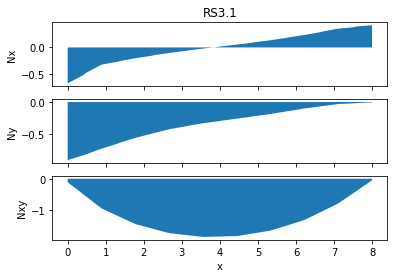

In [8]:
for id in ids:
    plotDiagrams(df.loc[df['ID'] == id])   

## Sammenligning med resultanter fra connections i FEM-design
Snitt i Y-retning:
Figuren under viser godt samsvar mellom resultanter fra FEM-desingn og resultanter beregnet her.

In [15]:
df_resultant.iloc[3:]

,Case,ID,Mnx,Mny,Nnx,Nny,V
3,enhetslast,RS1.1,4.85,4.59,-0.0,-2.72,10.5
4,enhetslast,RS2.1,59.96,6.40,-0.0,-4.01,0.0
5,enhetslast,RS3.1,4.85,4.59,-0.0,-2.72,-10.5


![Resultater_connections](figur2.png "FEM-Resultater")

Snitt i x-retning: Finner ikke igjen verdiene av Nnx i tabellen fra FEM-design? De øvrige ser ut til å stemme bra

In [18]:
df_resultant.iloc[:3]

,Case,ID,Mnx,Mny,Nnx,Nny,V
0,enhetslast,P.1.1,0.0,0.0,-74.23,-21.33,0.0
1,enhetslast,P.1.2,-0.0,0.0,72.89,-0.34,-0.0
2,enhetslast,P.1.3,-0.0,0.0,0.40,-10.40,-0.0


![fig3](figur3.png "Line connection resultants . lengderetning")